# Inverted Pendulum Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0
    \end{bmatrix}
\end{equation*}
$$

In order to deal with potential angle wrap-around issues (i.e. $2\pi = 0$), we
augment the state as follows and use that instead:

$$
\begin{equation*}
\textbf{x}_{augmented} = \begin{bmatrix}
    \sin\theta & \cos\theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

**Note**: The torque is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
# from ilqr.examples.DampingPendulum import DampingPendulumDynamics

/home/stone/miniconda3/envs/koopman/lib/python3.8/site-packages/theano/configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    print("iteration", iteration_count, info, J_opt, final_state)

In [10]:
from ilqr.dynamics import FiniteDiffDynamics
from scipy.integrate import odeint
state_size = 2  # [position, velocity]
action_size = 1  # [force]


def f(x, u, i):
    """Dynamics model function.

    Args:
        x: State vector [state_size].
        u: Control vector [action_size].
        i: Current time step.

    Returns:
        Next state vector [state_size].
    """
    g = 10.0
    m = 1.0
    l = 1.0
    dt = 0.02
    th, thdot = x
    newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l ** 2) * u) * dt
    newth = th + newthdot * dt

    return np.array([newth, newthdot]).reshape(-1)

# NOTE: Unlike with AutoDiffDynamics, this is instantaneous, but will not be
# as accurate.
dynamics = FiniteDiffDynamics(f, state_size, action_size)

In [11]:
# Note that the augmented state is not all 0.
x_goal = np.array([0.0, 0.0])
Q = np.eye(dynamics.state_size)
Q[0, 0] = 5.0
Q[1, 1] = 0.01
Q_terminal = Q.copy()
R = 0.01*np.eye(1)
cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [12]:
N = 100
x0 = np.array([-3.0, 6.0])
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [13]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=20, on_iteration=on_iteration)

iteration 0 accepted 400.6337544266534 [0.18238397 3.75639465]
iteration 1 accepted 302.1171667984662 [0.14233815 1.51241664]
iteration 2 accepted 301.1166549559902 [0.01716242 0.20363816]
iteration 3 accepted 301.10142496385123 [0.00034934 0.0039305 ]
iteration 4 converged 301.10141928215825 [ 1.21500151e-05 -4.39859091e-06]


In [14]:
t = np.arange(N) * 0.02
theta = np.unwrap(xs[:, 0])  # Makes for smoother plots.
theta_dot = xs[:, 1]

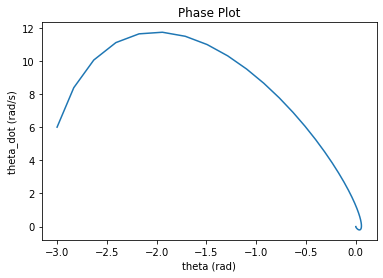

In [15]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Phase Plot")

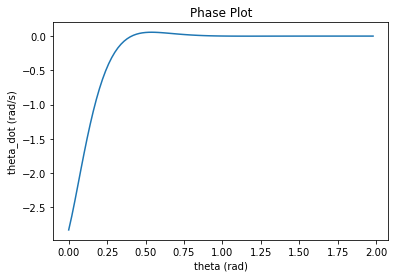

In [16]:
_ = plt.plot(t, theta[1:])
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Phase Plot")

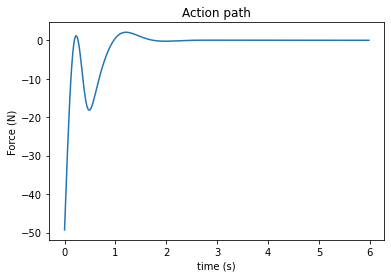

In [45]:
_ = plt.plot(t, us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

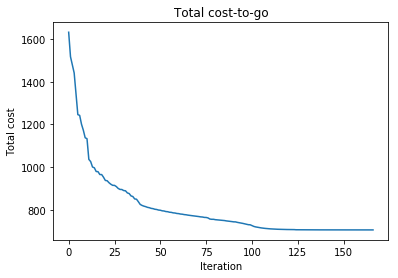

In [14]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")